In [90]:
import math
import numpy as np
import pandas as pd
# this gives us the data scaling we want to use on features
# which we generally want to scale between 1 and -1
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

In [91]:
#create a datatype for our files:
findt = dict(names = ('Date','Price'),formats=('S12',np.float32))

In [92]:
#load the files into arrays
#eur = np.loadtxt('euroFREDcsv.csv',delimiter=",",dtype=findt)

In [93]:
# load files with pandas
euro = pd.read_csv('euroFREDcsv.csv', usecols=[0,1])
spx = pd.read_csv('sp500FREDcsv.csv', usecols=[0,1])
yen = pd.read_csv('yenFREDcsv.csv', usecols=[0,1])

In [94]:
euro.shape, spx.shape, yen.shape

((4545, 2), (2610, 2), (11850, 2))

In [95]:
euro.columns = ['Date','Price']
spx.columns = ['Date','Price']
yen.columns = ['Date','Price']

In [96]:
# show rows with zero values:
#euro['Price'] == 0.0
#euroclean = euro[(euro['Price'] !=0).any()]
#euro.loc[~(euro['Price']==0).all(axis=1)]
#euro['Price'].loc[(euro['Price']!=0).any(1)]
# euroclean = euro.drop()

In [97]:
euroclean = euro[euro['Price'] > 0]
spxclean = spx[spx['Price'] > 0]
yenclean = yen[yen['Price'] > 0]

In [98]:
#np intersect1d
datearray = np.intersect1d(euroclean['Date'],spxclean['Date'])

In [99]:
datearray = np.intersect1d(datearray,yenclean['Date'])
datearray = pd.to_datetime(datearray)
datearray

DatetimeIndex(['2006-06-08', '2006-06-09', '2006-06-12', '2006-06-13',
               '2006-06-14', '2006-06-15', '2006-06-16', '2006-06-19',
               '2006-06-20', '2006-06-21',
               ...
               '2016-05-20', '2016-05-23', '2016-05-24', '2016-05-25',
               '2016-05-26', '2016-05-27', '2016-05-31', '2016-06-01',
               '2016-06-02', '2016-06-03'],
              dtype='datetime64[ns]', length=2495, freq=None)

In [100]:
import warnings
warnings.filterwarnings('ignore')

In [101]:
#euroclean[euroclean['Date'] == '2006-06-12']
#euroclean['Date'].max()
#euroclean['Date'].min()

In [102]:
# recast the data column as a datetime object
yenclean['Date'] = pd.to_datetime(yenclean['Date'])
euroclean['Date'] = pd.to_datetime(euroclean['Date'])
spxclean['Date'] = pd.to_datetime(spxclean['Date'])
# re-index the series to the date
yenclean.index = pd.DatetimeIndex(yenclean['Date'])
euroclean.index = pd.DatetimeIndex(euroclean['Date'])
spxclean.index = pd.DatetimeIndex(spxclean['Date'])


In [103]:
# now get the values of the data corresponding to the datearray dates
# .ix returns values at locations where indices = to value in datearray
df = pd.DataFrame({"Euro":euroclean.ix[datearray]['Price'],"Yen":yenclean.ix[datearray]['Price'],"Spx":spxclean.ix[datearray]['Price']},index=datearray)

Populating the interactive namespace from numpy and matplotlib


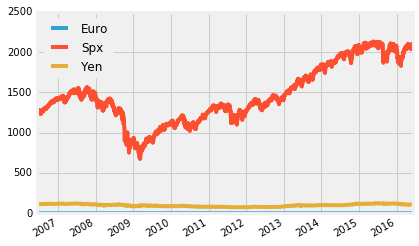

In [104]:
%pylab inline
df.plot()

In [105]:
# create %price change feature
df['Eurochg'] = df['Euro'].pct_change()
df['Yenchg'] = df['Yen'].pct_change()
df['Spxchg'] = df['Spx'].pct_change()

In [106]:
df['Euro'].corr(df['Yen'], method = 'spearman')

-0.29936051607718339

In [107]:
df['Euro'].corr(df['Yen'], method = 'pearson')

-0.35883200507523244

In [108]:
df['Euro'].corr(df['Yen'], method = 'kendall')

-0.19111675763432037

In [109]:
# create feature for biggest change rank
# though not sure if just having rank among 
# only these 3 series is meaningful but what the hell
# df = pd.DataFrame
# ({"Euro":euroclean.ix[datearray]['Price'],"Yen":yenclean.ix[datearray]['Price'],"Spx":spxclean.ix[datearray]['Price']},index=datearray)
# HOW DO I MAKE THE CHANGES ABSOLUTE VALUES ??
changes = pd.DataFrame({'Eurochg': df.ix[datearray]['Eurochg'],"Yenchg":df.ix[datearray]['Yenchg'],"Spxchg":df.ix[datearray]['Spxchg']},index=datearray)

In [110]:
ranks = changes.rank(1,ascending=False)
ranks[0:5]

,Eurochg,Spxchg,Yenchg
2006-06-08,NaN,NaN,NaN
2006-06-09,1.0,3.0,2.0
2006-06-12,2.0,3.0,1.0
2006-06-13,2.0,3.0,1.0
2006-06-14,2.0,1.0,3.0


In [111]:
abschanges = abs(changes)
absranks = abschanges.rank(1,ascending=False)
absranks[0:5]

,Eurochg,Spxchg,Yenchg
2006-06-08,NaN,NaN,NaN
2006-06-09,3.0,1.0,2.0
2006-06-12,2.0,1.0,3.0
2006-06-13,3.0,1.0,2.0
2006-06-14,2.0,1.0,3.0


In [112]:
# add the basic ranked feature to the dataframe:
df['Eurorank'] = ranks['Eurochg']
df['Yenrank'] = ranks['Yenchg']
df['Spxrank'] = ranks['Spxchg']

In [113]:
df[0:5]

,Euro,Spx,Yen,Eurochg,Yenchg,Spxchg,Eurorank,Yenrank,Spxrank
2006-06-08,1.2648,1257.93,114.22,NaN,NaN,NaN,NaN,NaN,NaN
2006-06-09,1.2636,1252.30,113.89,-0.000949,-0.002889,-0.004476,1.0,2.0,3.0
2006-06-12,1.2587,1236.40,114.17,-0.003878,0.002459,-0.012697,2.0,1.0,3.0
2006-06-13,1.2574,1223.69,115.06,-0.001033,0.007795,-0.010280,2.0,1.0,3.0
2006-06-14,1.2631,1230.04,114.85,0.004533,-0.001825,0.005189,2.0,3.0,1.0


In [114]:
# slice off the first row of df since incomplete data
df2 = df[1:]
df2[0:3]

,Euro,Spx,Yen,Eurochg,Yenchg,Spxchg,Eurorank,Yenrank,Spxrank
2006-06-09,1.2636,1252.30,113.89,-0.000949,-0.002889,-0.004476,1.0,2.0,3.0
2006-06-12,1.2587,1236.40,114.17,-0.003878,0.002459,-0.012697,2.0,1.0,3.0
2006-06-13,1.2574,1223.69,115.06,-0.001033,0.007795,-0.010280,2.0,1.0,3.0


#### Patterns To Do
A few more ideas about what to do:
> find all of the n-day moves of greater than X%
> extract features from the patterns immediately preceding them

Populating the interactive namespace from numpy and matplotlib


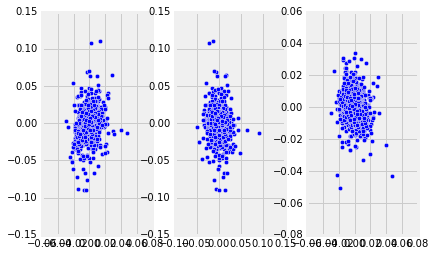

In [115]:
# plotting Yenchg vs Spxchg
%pylab inline
subplot(131)
scatter(df2['Eurochg'],df2['Spxchg'])
subplot(132)
scatter((df2['Eurochg']-df2['Yenchg']),df2['Spxchg'])
subplot(133)
scatter(df2['Eurochg'],df2['Yenchg'])

### Basic Model Fitting
Create a **training set** and a **test** set

In [116]:
# half of data
# TypeError: cannot do slice indexing on <class 'pandas.tseries.index.DatetimeIndex'> 
Y = df2['Spxchg']
X = (df2['Eurochg']-df2['Yenchg'])
half = int(floor(len(Y)/2))
train_X = X.iloc[:half]
train_Y = Y.iloc[:half]
test_X = X.iloc[half:]
test_Y = Y.iloc[half:]
# reshape the data
X_train_reshape = train_X[:,None]
X_test_reshape = test_X[:,None]
Y_train_reshape = train_Y[:,None]
Y_test_reshape = test_Y[:,None]

In [117]:
int(floor(len(Y)/2)), len(Y)

(1247, 2494)

#### Linear Regression

In [118]:
from sklearn import linear_model
clf = linear_model.LinearRegression(n_jobs=-1)
clf

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [119]:
# fit the model
clf.fit(X_train_reshape, Y_train_reshape)
# now do the prediction
Y_lr_pred = clf.predict(X_test_reshape)
# and check our mean squared error:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test_reshape,Y_lr_pred); 
accuracy = clf.score(X_test_reshape,Y_test_reshape)
print(mse, accuracy)

(9.936410591250402e-05, -0.011824214061817218)


In [120]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [121]:
# create data offset for use in autocorrelation and prediction:
def createOffset(x,y,offset=1):
    # shifted_x = x[:len(x)-offset]
    shifted_x = x[:-offset]
    shifted_y = y[offset:]
    return shifted_x, shifted_y

In [122]:
# creating offset for prediction - am I using the right inputs?
shiftx, shifty = createOffset(Y_lr_pred,Y_lr_pred,offset=1)

AttributeError: 'function' object has no attribute 'coef_'

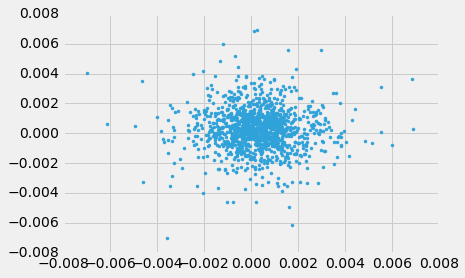

In [123]:
# visualize the model - hmm - no LR line - what happened?
# model is: y = Ax +b where x is the input and A and b are parameters
plot(shiftx, shifty, linestyle='None', marker = '.')
# linspace just creating a grid to plot things on
plot(linspace(0,20,100), clf.coef_[0,0] *linspace(0,20,100) + clf.intercept_[0])

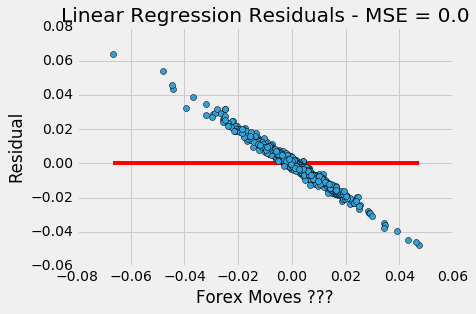

In [124]:
plot(Y_test_reshape,Y_lr_pred - Y_test_reshape, 'o')
title("Linear Regression Residuals - MSE = %.1f" % mse)
xlabel("Forex Moves ???")
ylabel("Residual")
hlines(0,min(Y_test_reshape),max(Y_test_reshape),color='red')

### k-Nearest Neighbor (KNN) Regression

In [125]:
from sklearn import neighbors
from sklearn import preprocessing
knn_X_train = preprocessing.scale(X_train_reshape) # many methods work better on scaled X
knn_X_test = preprocessing.scale(X_test_reshape)
knn_clf = neighbors.KNeighborsRegressor(5) # what's the purpose of the 5?
knn_clf.fit(knn_X_train,Y_train_reshape) # am I putting in the right things here?

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

(0.00014939289215088605, -0.52126710444208957)


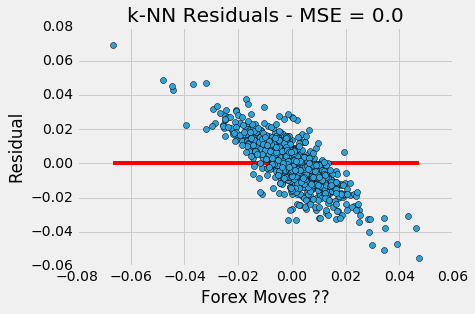

In [126]:
Y_knn_pred = knn_clf.predict(knn_X_test)
knn_mse = mean_squared_error(Y_test_reshape,Y_knn_pred);
knn_accuracy = knn_clf.score(knn_X_test,Y_test_reshape)
print(knn_mse, knn_accuracy)
plot(Y_test_reshape, Y_knn_pred - Y_test_reshape, 'o') # what does the 'o' do?
title("k-NN Residuals - MSE = %.1f" % mse)
xlabel("Forex Moves ??")
ylabel("Residual")
hlines(0,min(Y_test_reshape),max(Y_test_reshape),color='red')

### Identifying big moves

In [127]:
# get the original dataframe - before all the reshaping I guess?
df2[0:3]

,Euro,Spx,Yen,Eurochg,Yenchg,Spxchg,Eurorank,Yenrank,Spxrank
2006-06-09,1.2636,1252.30,113.89,-0.000949,-0.002889,-0.004476,1.0,2.0,3.0
2006-06-12,1.2587,1236.40,114.17,-0.003878,0.002459,-0.012697,2.0,1.0,3.0
2006-06-13,1.2574,1223.69,115.06,-0.001033,0.007795,-0.010280,2.0,1.0,3.0


In [128]:
# Let's just work with spx for now
# create new datatframe:
spx2 = spxclean.copy()
spx2[0:5]

,Date,Price
2006-06-08,2006-06-08,1257.93
2006-06-09,2006-06-09,1252.30
2006-06-12,2006-06-12,1236.40
2006-06-13,2006-06-13,1223.69
2006-06-14,2006-06-14,1230.04


In [129]:
# add 3 day, 5 day, 16 day and 39 day rolling pct change
spx2['chg3'] = spx2['Price'].pct_change(3)
spx2['chg5'] = spx2['Price'].pct_change(5)
spx2['chg16'] = spx2['Price'].pct_change(16)
spx2['chg39'] = spx2['Price'].pct_change(39)
spx2[39:45]

,Date,Price,chg3,chg5,chg16,chg39
2006-08-03,2006-08-03,1280.27,0.002828,0.013513,0.017218,0.017759
2006-08-04,2006-08-04,1279.36,0.006641,0.000634,0.029840,0.021608
2006-08-07,2006-08-07,1275.77,-0.002174,-0.000697,0.032009,0.031842
2006-08-08,2006-08-08,1271.48,-0.006866,0.000441,0.029964,0.039054
2006-08-09,2006-08-09,1265.95,-0.010482,-0.009855,0.023519,0.029194
2006-08-10,2006-08-10,1271.81,-0.003104,-0.006608,0.009525,0.012459


In [130]:
# identify mean and std of the pct change data
# I should probably write a function to iterate through but can't be bothered
chg3mean = spx2['chg3'].mean()
chg3std = spx2['chg3'].std()
chg5mean = spx2['chg5'].mean()
chg5std = spx2['chg5'].std()
chg16mean = spx2['chg16'].mean()
chg16std = spx2['chg16'].std()
chg39mean = spx2['chg39'].mean()
chg39std = spx2['chg39'].std()

In [131]:
spx_chg3_df = spx2['chg3']
spx_chg3_df = spx_chg3_df[3:]
spx_chg3_df[0:6]

2006-06-13   -0.027219
2006-06-14   -0.017775
2006-06-15    0.015982
2006-06-16    0.022759
2006-06-19    0.008211
2006-06-20   -0.012769
Name: chg3, dtype: float64

In [132]:
# Now create a dataframe with all of the biggest surges (up) and surges (down) along with their antecedents
def findBigMoves(df,stds=2.0):
    #takes input of %change as df
    results ={}
    avg = df.mean()
    sdv = df.std()
    for idx, item in enumerate(df):
        if abs(item) > (avg+(sdv*stds)):
            results[idx] = item
    return results

In [133]:
# now how do I get it to return the date as well?
bm3 = findBigMoves(spx_chg3_df,stds=5)
bm3

{584: -0.10594285098897938,
 585: -0.10397278094666262,
 586: -0.1390589370700831,
 601: 0.12388682090185177,
 616: -0.11555686159271228,
 619: 0.1394795598320131,
 620: 0.10955839156031644,
 691: 0.10969210530205609,
 1298: -0.11177936112477582}

In [ ]:
# plotting distribution of 3d %chg just for fun - is there a way
# to iterate through distributions to see which one matches the best?
# and is that a sensible idea?
spx2['chg3'].hist(bins=100)
plt.axvline(x=chg3mean+chg3std,linewidth=1) # +1 std
plt.axvline(x=chg3mean-chg3std,linewidth=1) # -1 std
plt.axvline(x=chg3mean+(chg3std*2),linewidth=3) # +2 std
plt.axvline(x=chg3mean-(chg3std*2),linewidth=3) # -2 std
xlim([-0.1,0.1])

In [89]:
# now that we can get the big moves, let's try and classify them...